In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('cardataformodel.csv')
data.head()

,Make,Colour,Odometer (KM),Doors,Seats,Fuel Milage,Total Fuel Used,Price
0,Honda,White,35431.0,4.0,5,5.38,6585.69,15323.0
1,BMW,Blue,192714.0,5.0,5,3.89,49540.87,19943.0
2,Honda,White,84714.0,4.0,5,3.72,22772.58,28343.0
3,Toyota,White,154365.0,4.0,5,4.28,36066.59,13434.0
4,Nissan,Blue,181577.0,3.0,5,4.49,40440.31,14043.0


In [3]:
data.isnull().sum()

Make               0
Colour             0
Odometer (KM)      0
Doors              0
Seats              0
Fuel Milage        0
Total Fuel Used    0
Price              0
dtype: int64

In [4]:
data.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
946    False
947    False
948    False
949    False
950    False
Length: 951, dtype: bool

In [5]:
data['Odometer (KM)'] = pd.to_numeric(data['Odometer (KM)'], errors='coerce')
data['Doors'] = pd.to_numeric(data['Doors'], errors='coerce')
data['Seats'] = pd.to_numeric(data['Seats'], errors='coerce')
data['Fuel Milage'] = pd.to_numeric(data['Fuel Milage'], errors='coerce')
data['Total Fuel Used'] = pd.to_numeric(data['Total Fuel Used'], errors='coerce')
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

In [6]:
X = data.drop('Price', axis=1)
y = data['Price']

In [7]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Defining preprocessing steps
numeric_features = ['Odometer (KM)', 'Doors', 'Seats', 'Fuel Milage', 'Total Fuel Used']
categorical_features = ['Make', 'Colour']

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

In [10]:
# Creating the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])


In [11]:
# Defining hyperparameter grid for tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5]
}


GridSearchCV is a technique used in machine learning for hyperparameter optimization

In [12]:
# Performing GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [10, 20, ...], 'regressor__min_samples_split': [2, 5], 'regressor__n_estimators': [100, 200]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [13]:
best_model = grid_search.best_estimator_


In [14]:
# Making prediction
y_pred = best_model.predict(X_test)

In [15]:
# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [16]:
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Best Parameters: {grid_search.best_params_}")

Mean Absolute Error: 5728.14
R² Score: 0.17
Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}


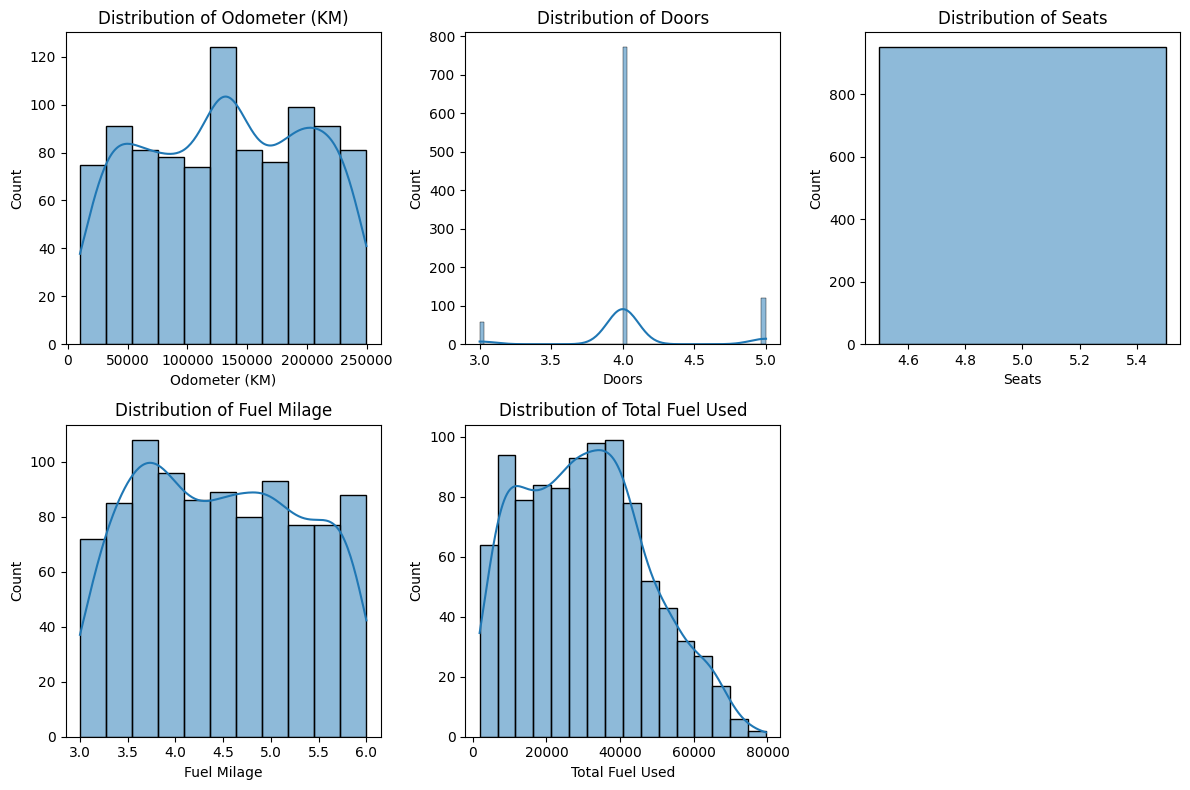

In [17]:
# Visualizing feature distributions
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('feature_distributions.png')
# plt.close()

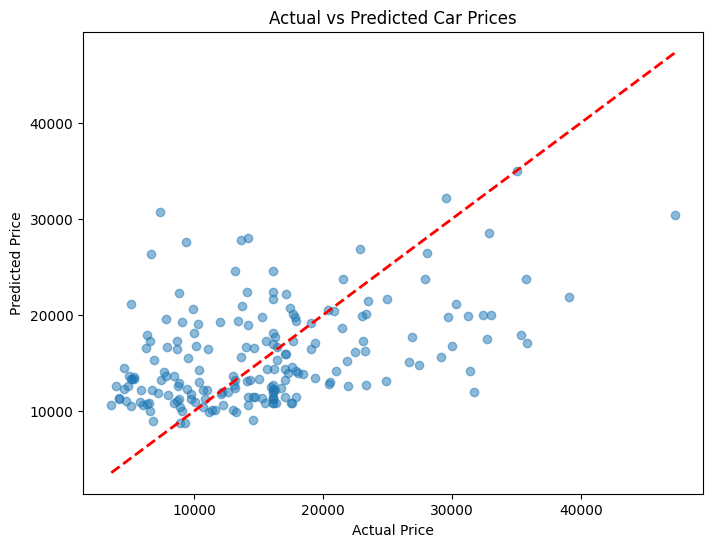

In [20]:
# Visualizing actual vs predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.savefig('actual_vs_predicted.png')
# plt.close()

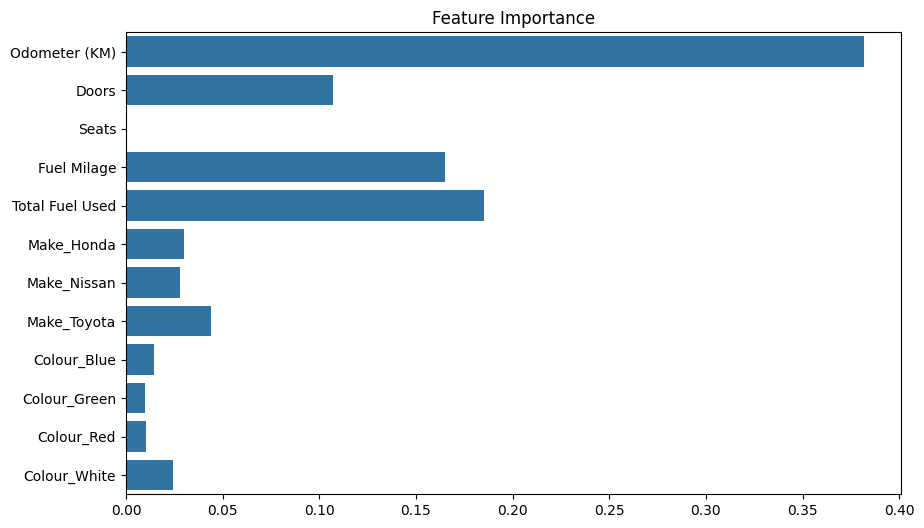

In [21]:
# Feature importance
feature_names = (numeric_features + 
                 best_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())
importances = best_model.named_steps['regressor'].feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.savefig('feature_importance.png')
# plt.close()


In [22]:
# Function to predict price for new car data
def predict_car_price(make, colour, odometer, doors, seats, fuel_milage, total_fuel_used):
    input_data = pd.DataFrame({
        'Make': [make],
        'Colour': [colour],
        'Odometer (KM)': [odometer],
        'Doors': [doors],
        'Seats': [seats],
        'Fuel Milage': [fuel_milage],
        'Total Fuel Used': [total_fuel_used]
    })
    predicted_price = best_model.predict(input_data)[0]
    return predicted_price

# Example prediction
example_price = predict_car_price('Honda', 'White', 50000, 4, 5, 5.0, 10000)
print(f"Predicted price for example car: ${example_price:.2f}")


Predicted price for example car: $17676.05


In [23]:
# Saving the model
import joblib
joblib.dump(best_model, 'car_price_model.pkl')

['car_price_model.pkl']